In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### LOAD DATA ###

In [3]:
def load_and_prepare_data(file_path1, file_path2):
    try:
        data1 = pd.read_csv(file_path1, encoding='latin-1')
        print("CSV File 1 loaded successfully.")
    except FileNotFoundError:
        print("File 1 not found. Make sure to provide the correct path.")
        return None, None

    try:
        data2 = pd.read_csv(file_path2, encoding='latin-1')
        print("CSV File 2 loaded successfully.")
    except FileNotFoundError:
        print("File 2 not found. Make sure to provide the correct path.")
        return None, None

    return data1, data2

In [4]:
#### OVERLAP WINDOW ####

In [5]:
def process_data(dataframe_sane, dataframe_malicious, window_size):    # Convert the 'Time' column to a datetime object
    dataframe_sane['Time'] = pd.to_datetime(dataframe_sane['Time'], unit='s')
    dataframe_malicious['Time'] = pd.to_datetime(dataframe_malicious['Time'], unit='s')

    # Calculate the sum of TCP packets received per rolling window for both DataFrames
    data_sane_seconds = dataframe_sane[dataframe_sane['Protocol'] == 'TCP'].resample('1S', on='Time').size().reset_index(name='Packets')
    data_sane_window = data_sane_seconds.rolling(window_size, on='Time').sum()

    data_malicious_seconds = dataframe_malicious[dataframe_malicious['Protocol'] == 'TCP'].resample('1S', on='Time').size().reset_index(name='Packets')
    data_malicious_window = data_malicious_seconds.rolling(window_size, on='Time').sum()

    # Drop the NaN values from both DataFrames
    data_sane_window = data_sane_window.dropna()
    data_malicious_window = data_malicious_window.dropna()

    # Reset the index of both DataFrames
    data_sane_window = data_sane_window.reset_index(drop=True)
    data_malicious_window = data_malicious_window.reset_index(drop=True)
    
    return data_sane_window, data_malicious_window

In [6]:
def align_data_lengths(data1, data2):
    min_length = min(len(data1), len(data2))
    data1 = data1[:min_length]
    data2 = data2[:min_length]
    return data1, data2

In [7]:
#### ANOMALIES ####

In [8]:
def calculate_anomalies(mean, data, threshold):
    # Create a list of boolean values where True means that the value is greater than the mean + threshold
    #anomaly = [1 if i > mean_packets1 + threshold else 0 for i in tcp_packets_window2['Packets']]
    anomaly = [i > mean + threshold for i in data['Packets']]

    # Print the number of anomalies
    print("Number of anomalies:", sum(anomaly))

    return anomaly

In [9]:
### BANDS ###

In [10]:
def compute_bands(dataframe):
    # Compute upper and lower bands using the lambda function
    get_bands = lambda data: (np.mean(data) + 3 * np.std(data), np.mean(data) - 3 * np.std(data))
    upper_bands, lower_bands = get_bands(dataframe['Packets'])

    # Add upper and lower bands columns to the dataframe
    dataframe['Upper_Band'] = upper_bands
    dataframe['Lower_Band'] = lower_bands

In [11]:
### PLOT DATAGRAM ###

In [12]:
def plot_packets(data1, data2, anomaly_indices=None, attack_phase=None):
    # Plot the TCP packets per second for first DataFrame with the upper and lower bands with index windows as x-axis
    plt.figure(figsize=(10*1.2, 4*1.2))
    plt.plot(data2.index, data2['Packets'], label='TCP Packets per Second')
    plt.plot(data1.index, data1['Upper_Band'], label='Upper Band', linestyle='dashed', color='r')
    plt.plot(data1.index, data1['Lower_Band'], label='Lower Band', linestyle='dashed', color='g')
    plt.axvspan(31, 91, facecolor=(50/255, 50/255, 50/255), alpha=0.1, label='Attack Phase')
    # Plot the anomalies
    plt.scatter(data2.index[anomalies], data2['Packets'][anomalies], label='Anomaly', color='r')
    
    
    plt.xlabel('Window Index')
    plt.ylabel('Num. of TCP Packets')
    plt.title('TCP Packets per Second')
    plt.legend()
    plt.grid(True)
    plt.show()


In [13]:
def plot_traffic_comparison(data1, data2, attack_phase=None):
    plt.figure(figsize=(10, 4))
    plt.plot(data1.index, data1['Packets'], label='Legitimate Traffic')
    plt.plot(data2.index, data2['Packets'], label='Attack Traffic')
    plt.xlabel('Window Index')
    plt.ylabel('Num. of TCP Packets')
    plt.title('TCP Packets per Second')
    
    if attack_phase:
        plt.axvspan(*attack_phase, facecolor=(50/255, 50/255, 50/255), alpha=0.1, label='Attack Phase')

    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
### MAIN ###

In [14]:
# Define the paths of the CSV files
file_path1 = '100_fermosave.csv'
file_path2 = '40_100_fermoattack.csv'

training_sane, training_malicious = load_and_prepare_data(file_path1, file_path2)
print()
tcp_packets_window1, tcp_packets_window2 = process_data(training_sane, training_malicious, window_size=10)

CSV File 1 loaded successfully.
CSV File 2 loaded successfully.



In [15]:
# Calculate the standard deviation of the TCP packets received per rolling window for the first DataFrame
std1 = tcp_packets_window1['Packets'].std()
print("Standard deviation of the first DataFrame: ", std1)

# Calculate the standard deviation of the TCP packets received per rolling window for the second DataFrame
std2 = tcp_packets_window2['Packets'].std()
print("Standard deviation of the second DataFrame: ", std2)

Standard deviation of the first DataFrame:  488.5292283739357
Standard deviation of the second DataFrame:  1816.7482460595468


In [16]:
print(tcp_packets_window1)
print(tcp_packets_window2)

                  Time  Packets
0  1970-01-01 00:00:09  25050.0
1  1970-01-01 00:00:10  25278.0
2  1970-01-01 00:00:11  25301.0
3  1970-01-01 00:00:12  25477.0
4  1970-01-01 00:00:13  25859.0
..                 ...      ...
87 1970-01-01 00:01:36  26111.0
88 1970-01-01 00:01:37  25737.0
89 1970-01-01 00:01:38  25790.0
90 1970-01-01 00:01:39  25610.0
91 1970-01-01 00:01:40  24953.0

[92 rows x 2 columns]
                  Time  Packets
0  1970-01-01 00:00:09  24875.0
1  1970-01-01 00:00:10  25321.0
2  1970-01-01 00:00:11  25568.0
3  1970-01-01 00:00:12  25832.0
4  1970-01-01 00:00:13  26054.0
..                 ...      ...
87 1970-01-01 00:01:36  29667.0
88 1970-01-01 00:01:37  29665.0
89 1970-01-01 00:01:38  29701.0
90 1970-01-01 00:01:39  29652.0
91 1970-01-01 00:01:40  28475.0

[92 rows x 2 columns]


In [17]:
# Calculate the mean of received packets per second for both datasets
mean_packets1 = tcp_packets_window1['Packets'].mean()
mean_packets2 = tcp_packets_window2['Packets'].mean()

print("First dataset mean frequency TCP packet:  ", mean_packets1)
print("Second dataset mean frequency TCP packet: ", mean_packets2)

First dataset mean frequency TCP packet:   26656.630434782608
Second dataset mean frequency TCP packet:  28983.75


In [18]:
threshold = std1 * 3
anomalies = calculate_anomalies(mean_packets1, tcp_packets_window2, threshold)

for i in range(len(anomalies)):
    if anomalies[i] == 1:
        print ("Alert: A network attack might be occurring.")
        break

Number of anomalies: 54
Alert: A network attack might be occurring.


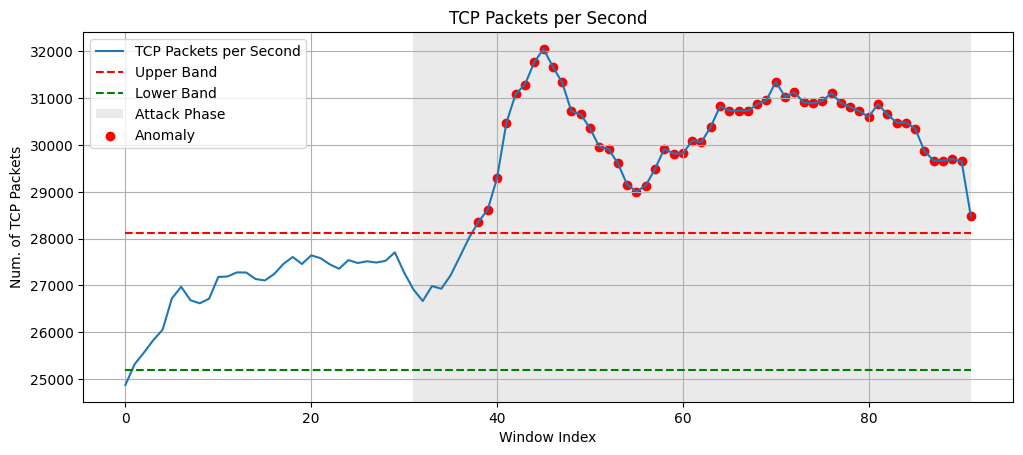

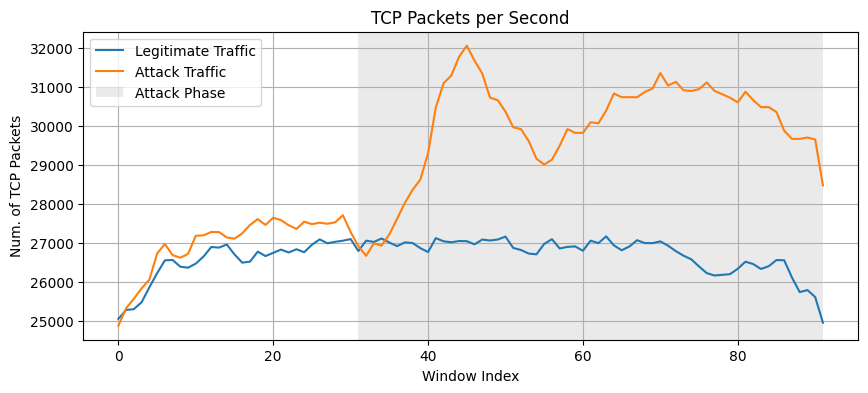

In [19]:
compute_bands(tcp_packets_window1)
tcp_packets_window1, tcp_packets_window2 = align_data_lengths(tcp_packets_window1, tcp_packets_window2)

attack_phase = (31, 91) 

plot_packets(tcp_packets_window1, tcp_packets_window2, anomalies, attack_phase)
plot_traffic_comparison(tcp_packets_window1, tcp_packets_window2, attack_phase)

In [33]:
### EVALUATION ###

In [20]:
# Define the paths of the CSV files
file_path_sane = '100_fullsane.csv'
file_path_malicious = '100_fullattack.csv'

sane_test, malicious_test = load_and_prepare_data(file_path_sane, file_path_malicious)
print()
testing_sane_window, testing_malicious_window = process_data(training_sane, training_malicious, window_size=10)


CSV File 1 loaded successfully.
CSV File 2 loaded successfully.



In [21]:
pd.set_option('display.max_rows', None)

#print(testing_sane_window)
#print(testing_malicious_window)

In [22]:
# Concatenate the two lists
concatenated_data = pd.concat([testing_sane_window, testing_malicious_window], ignore_index=True)

#print(concatenated_data)

In [23]:
anomalies_real = calculate_anomalies(mean_packets1, concatenated_data, threshold)

Number of anomalies: 54


In [24]:
print(len(anomalies_real))

184


In [25]:
# Make a list with only False values with the lenght of the testing_sane_window
anomalies_test = [False] * len(testing_sane_window)

# Make a list with only True values with the lenght of the testing_malicious_window
anomalies_test2 = [True] * len(testing_malicious_window)

# Concatenate the two lists
anomalies_test = anomalies_test + anomalies_test2

In [26]:
print(len(anomalies_test))

184


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate evaluation metrics
accuracy = accuracy_score(anomalies_test, anomalies_real)
precision = precision_score(anomalies_test, anomalies_real)
recall = recall_score(anomalies_test, anomalies_real)
f1 = f1_score(anomalies_test, anomalies_real)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(anomalies_test, anomalies_real)

# Create a DataFrame from the confusion matrix
confusion_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print()
print("Confusion Matrix:")
print(confusion_df)

Accuracy: 0.7934782608695652
Precision: 1.0
Recall: 0.5869565217391305
F1-score: 0.7397260273972603

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                  92                   0
Actual Positive                  38                  54
